In [1]:
%matplotlib inline

# Module 8 - Programming Assignment (Summer)

## Directions

There are general instructions on Blackboard and in the Syllabus for Programming Assignments. This Notebook also has instructions specific to this assignment. Read all the instructions carefully and make sure you understand them. Please ask questions on the discussion boards or email me at `EN605.445@gmail.com` if you do not understand something.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
You must follow the directions *exactly* or you will get a 0 on the assignment.
</div>

You must submit *only* your IPython notebook to Blackboard. It should be cleanly executed and named:

```
<jhed_id>.ipynb
```

An HTML version of the notebook will be generated and graded and the notebook will be used only for reference. To see what the HTML version of your notebook will look like, apply the following command:

> ipython nbconvert <jhed_id>.ipynb

or use the File menu.

# The Problem

When we last left our agent in Module 4, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

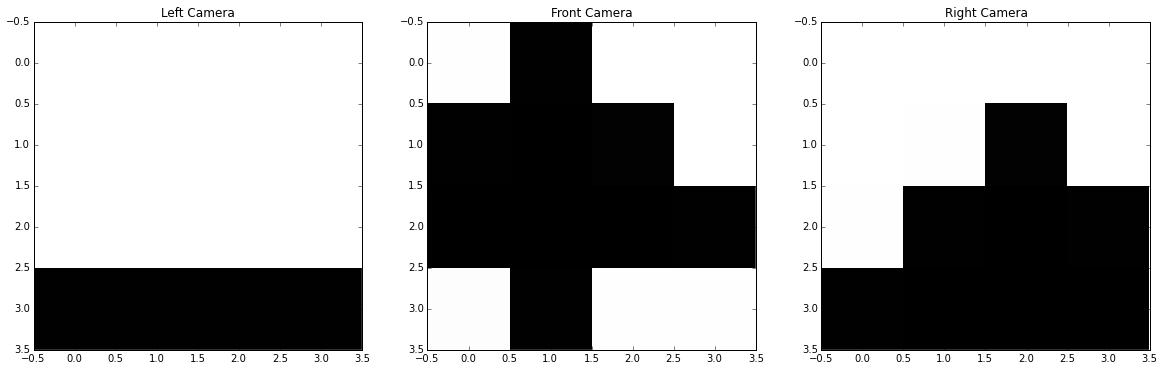

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import HTML, display

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray', interpolation='none')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray', interpolation='none')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray', interpolation='none')

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write a logistic regression that simply determines if something is a hill or not (two class problem). 
2. You will also evaluate that logistic regression by generating a *confusion matrix*.

For a starting point, you can refer to **module-8-pseudocode.pdf** and the Self-Check.

## Data

We have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often blurry.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray', interpolation='none')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

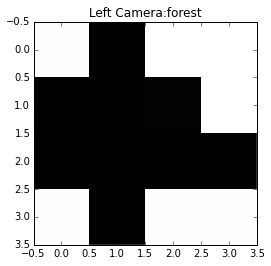

In [5]:
view_sensor_image( clean_data[ "forest"][0])

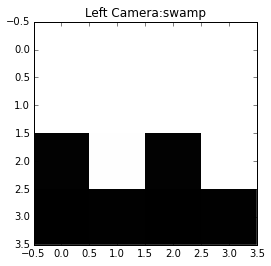

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

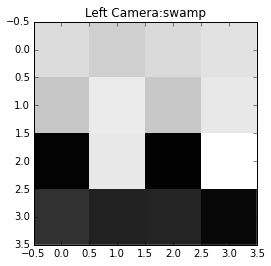

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

You are going to want to write four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `calculate_confusion_matrix`


### `generate_data`

With the clean examples and the `blur` function, we have an unlimited amount of data for training and testing our classifier, a logistic regression that determines if a sensor image is hills (1) or not (0).

In classification, there is a general problem called the "unbalanced class problem". In general, we want our training data to have the same number of classes, in this case "hills" and "not hills". This means you should probably generate training data with, say, 100 hills and then 100 of all the other types of terrain combined.

When you send your data to the actual `learn_model` function, it will need to have all the String labels transformed to 0 or 1 appropriately. Remember, you also need to set $x_0$ = 1.0; *where* you do that is up to you but you need to be consistent (if you do it in `generate_data` then don't also do it in `learn_model` or `apply_model`.

You can make `generate_data` as sophisticated as you like. But it should at least take n and a label so that:

`generate_data( clean_data, 100, "hills")`

generates 100 hills, 100 not hills and has transformed the String labels into 1 and 0, respectively.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the logistic regression model. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

I should also mention that gradient descent is not the usual approach to linear|logistic regression because the error function actually has an *exact* solution. However, in the case of large data sets, the exact solution often fails and in any case, the use of gradient descent will prepare you for neural networks next week.

When verbose is True, you should print out the error so you can see that it is getting smaller. 

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the List of Thetas.

### `apply_model`

`apply_model` takes a List of Thetas (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a Tuple of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.19).

If the data is labeled, you will return a Tuple of the actual value (0 or 1) and the predicted value (0 or 1). In this case, you return a List of something like [(0, 1), (1, 1), (0, 0), (1, 0)].

### `calculate_confusion_matrix`

The `calculate_confusion_matrix` takes the results of `apply_model` when labeled=True and prints a nice HTML version of a confusion matrix and include statistics for error rate, true positive rate and true negative rate.


**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you intend (and not to be modifying a copy)**

---

## Helper functions

**logistic(x, theta)**  
Given a matrix x and a vector $\theta$, calculate the logistic function:  
$$ \hat{y}= \frac{1}{1+e^{-\mathbf{x} \mathbf{\theta}}} $$

**logisticError(x, theta, y)**  
Calculate the error of the logistic regression given a matrix of `x`, a vector of $\theta$, and actual value `y`. 
$$Err(\mathbf{x},\mathbf{\theta},\mathbf{y})=-\frac{1}{n}\sum_i	y_i	log(\hat{y_i}) + (1	- y_i)log(1	- \hat{y_i})$$

**updateTheta(a, yhat, y, x, th, errDiff)**  
Update the $\theta$ based on $\hat{y}$ and $\alpha$, using the equation  
$$\frac{\partial J}{\partial \theta_j} = \frac{1}{n}\sum_i(\hat{y_i}  - y_i)x_{ij}$$
$$\theta_{t+1} = \theta_{t} - \alpha \cdot \frac{\partial J}{\partial \theta_j}$$

**makeIndepDepData(data)**  
Given a matrix of input data of dimension i x j, where the first j-1 columns are the independent variables, and column j is the actual, the function outputs matrix of the first j-1 columns prepended with a vertical vector of ones (for the intercept), and the y.

In [9]:
def logistic(x, theta):
    return 1.0 / ( 1 + np.exp(-x * theta) )

def logisticError(x, theta, y):
    yhat = logistic(x, theta)
    err = -(y.T*np.log(yhat) + (1-y).T*np.log(1-yhat)) / len(y)
    return float(err), yhat
    
def updateTheta(a, yhat, y, x, th, errDiff):
    d = ((yhat-y).T * x).T / len(y)
    return th - (a*d)

def makeIndepDepData(data):
    y = data[:, -1] # actual
    x = np.hstack((np.ones([data.shape[0],1]), data[:, :-1])) # put intercept
    return x,y

---

## Main Functions

Use `generate_data` to generate 10 blurred "hills" examples with balanced (same number of) "non hills" examples to see that the function is working.

**generate_data( data, n, label)**  
Generate n blurred data points of the `label` category by choosing instances of data points within that category, as well as n random blurred data points instances that belongs to other categories.

In [10]:
def generate_data( data, n, label):
    outK = [k for k in data.keys() if k!=label]
    inPts = [blur(data[label][random.randrange(len(data[label]))])[:-1] + [1] \
             for x in xrange(n)]
    outPts = list()
    for x in xrange(n):
        tp = random.sample(outK, 1)[0]
        outPts.append(blur(data[tp][random.randrange(len(data[tp]))][:-1]+[0]))
    return np.matrix(inPts + outPts)

results = generate_data( clean_data, 10, "hills")
for result in results:
    print result

[[ 0.          0.17146271  0.10637145  0.01514782  0.01838531  0.79727449
   0.06485791  0.13057679  1.          0.95043011  0.97706854  0.0680517
   0.88850549  1.          0.79890813  1.          1.        ]]
[[ 0.07334794  0.05365704  0.15780845  0.16127618  0.21795331  0.82052463
   0.06905308  0.0548153   0.95064927  1.          0.835222    0.05477571
   0.78332465  0.98219075  0.827884    1.          1.        ]]
[[ 0.1332295   0.05762474  0.07618189  0.10515962  0.08506358  0.06741011
   0.83497855  0.01237306  0.          1.          0.91064092  0.98260701
   0.88640081  0.89979134  0.85683882  0.98477143  1.        ]]
[[ 0.13942781  0.10076149  0.12382258  0.13156366  0.0653928   0.04687145
   0.11304692  0.92648591  0.11881225  0.16545565  0.8332642   0.81762471
   0.05978606  0.89064336  0.78728366  0.8889499   1.        ]]
[[ 0.19621836  0.00728214  0.11568984  0.11950618  0.08453366  0.82343186
   0.12237476  0.11121595  0.89297145  0.56709981  0.83686324  0.12652874
   0.

Use `learn_model` to learn a logistic regression model for classifying sensor images as "hills" or "not hills". Use your `generate_data` function to generate a training set with 100 hills examples. **Set Verbose to True**

**learn_model( data, alpha, eps, verbose=False)**  
Using gradient descent, fit a logistic regression to the input data by adjusting the parameters to find one that minimizes the error as calculated `logisticError()`. The algorithm runs until the successive differences between the errors of the iteration is less than `eps` in the parameter. Each iteration updates the $\theta$ according to the derivative. When the error difference increases, the alpha gets divided by 10. The algorithm goes for 1 million iterations before stopping, even though when the error difference has not reached epsilon yet.

In [11]:
def learn_model( data, alpha, eps, verbose=False):
    x,y = makeIndepDepData(data)
    theta = np.matrix(np.random.rand(x.shape[1],1)) # initialize Theta
    lastErr = 0
    err,yhat = logisticError(x, theta, y)

    c = 0
    while (abs(err-lastErr) > eps) and c<1e6:
        if c % 1000 == 0 and verbose:
            print('Iter #%u, error: %f'%(c,err))
        theta = updateTheta(alpha, yhat, y, x, theta, err-lastErr)
        lastErr = err
        err,yhat = logisticError(x, theta, y)
        if err > lastErr:
            alpha /= 10
        c += 1
    
    print('Final iteration #%u, error: %f' % (c-1,err) )
    print('Coefficients: %s' % str(theta.T))
    return theta


train_data = generate_data( clean_data, 100, "hills")
model = learn_model( train_data, 0.1, 1e-7, True)

Iter #0, error: 1.385071
Iter #1000, error: 0.386077
Iter #2000, error: 0.282118
Iter #3000, error: 0.228899
Iter #4000, error: 0.195539
Iter #5000, error: 0.172378
Iter #6000, error: 0.155238
Iter #7000, error: 0.141975
Iter #8000, error: 0.131366
Iter #9000, error: 0.122658
Iter #10000, error: 0.115361
Iter #11000, error: 0.109143
Iter #12000, error: 0.103770
Iter #13000, error: 0.099070
Iter #14000, error: 0.094919
Iter #15000, error: 0.091220
Iter #16000, error: 0.087898
Iter #17000, error: 0.084894
Iter #18000, error: 0.082163
Iter #19000, error: 0.079665
Iter #20000, error: 0.077371
Iter #21000, error: 0.075254
Iter #22000, error: 0.073293
Iter #23000, error: 0.071471
Iter #24000, error: 0.069771
Iter #25000, error: 0.068181
Iter #26000, error: 0.066690
Iter #27000, error: 0.065288
Iter #28000, error: 0.063966
Iter #29000, error: 0.062718
Iter #30000, error: 0.061537
Iter #31000, error: 0.060416
Iter #32000, error: 0.059352
Iter #33000, error: 0.058340
Iter #34000, error: 0.05737

Use `generate_data` to generate 100 blurred "hills" examples with balanced "non hills" examples and use this as your test data. Set labeled=True and generate results to use in `calculate_confusion_matrix`. Print out the first 10 results, one per line.

**apply_model( model, test_data, labeled=False)**  
Given a list of $\theta$, calculate the predicted $\hat{y}$ from the input data. If `labeled` is false, it returns tuples of predicated true/false as well as the actual probability. If not labeled, then return tuples of actual true/false and predicted true/false.

In [12]:
test_data = generate_data( clean_data, 100, "hills")

def apply_model( model, test_data, labeled=False):
    x,y = makeIndepDepData(test_data)
    yhat = logistic(x, model).T.tolist()[0]
    pred = [1 if n > 0.5 else 0 for n in yhat]
    if labeled:
        return zip([int(round(n)) for n in y.T.tolist()[0]], pred)
    else:
        return zip(pred, yhat)

results = apply_model( model, test_data, True)
for n in range(10):
    print results[n]

(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)


Using the results above, show your confusion matrix for your model.

**calculate_confusion_matrix(results)**  
Given a labeled result from `apply_model(...)`, prints an html table of confusion matrix. Also prints out the error rate, true positive rate, and true negative rate.

In [13]:
def calculate_confusion_matrix( results):
    h = [[0,0], [0,0]]
    for act,pred in results:
        h[act][pred] += 1
    t = [['n = %u'%len(results), 'Pred: False', 'Pred: True'],
         ['Actual: False'] + h[0], ['Actual: True'] + h[1]]
    s = '<table>%s</table>'%''.join(['<tr>%s</tr>'% ''.join(
                ['<td>%s</td>'%str(x) for x in row]) for row in t])
    print('')
    display(HTML(s))

    errRate = (h[0][1] + h[1][0] + 0.0) / len(results) * 100
    tpRate = h[1][1] / (h[1][0] + h[1][1] + 0.0) * 100
    tnRate = h[0][0] / (h[0][0] + h[0][1] + 0.0) * 100
    print('Error rate: %.1f%%' % errRate)
    print('True positive rate: %.1f%%' % tpRate)
    print('True negative rate: %.1f%%' % tnRate)

calculate_confusion_matrix(results)

n = 200,Pred: False,Pred: True
Actual: False,98,2
Actual: True,2,98


Error rate: 2.0%
True positive rate: 98.0%
True negative rate: 98.0%
